# Chapter 1

Implement a perceptron and adaptive linear classifier for the Iris dataset.

In [1]:
from dataclasses import dataclass, field
import warnings
from typing import List, Union

warnings.simplefilter('ignore')

import japanize_matplotlib
import matplotlib.pyplot as plt
import numpy as np
from numpy import ndarray
from numpy.random import RandomState
import pandas as pd
from pandas.core.frame import DataFrame
from pandas.core.series import Series

%matplotlib inline

In [2]:
URL = 'https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data'

In [3]:
names = [
    'sepal_length',
    'sepal_width',
    'petal_length',
    'petal_width',
    'class_label'
]
dtype = {
    'sepal_length': 'float',
    'sepal_width': 'float',
    'petal_length': 'float',
    'petal_width': 'float',
    'class_label': 'string'
}
df_iris = pd.read_csv(URL, header=None, names=names, dtype=dtype, encoding='utf-8')

df_iris.head()

,sepal_length,sepal_width,petal_length,petal_width,class_label
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa


Slice the sub-dataframe of instances labeled with `Iris-setosa` from the original dataset `df_iris` by
using the `.query` method. Show the descriptive statistics with `.describe` method.

In [4]:
df_iris_setosa = df_iris.query("class_label == 'Iris-setosa'")

df_iris_setosa.describe(include='all')

,sepal_length,sepal_width,petal_length,petal_width,class_label
count,50.00000,50.000000,50.000000,50.00000,50
unique,NaN,NaN,NaN,NaN,1
top,NaN,NaN,NaN,NaN,Iris-setosa
freq,NaN,NaN,NaN,NaN,50
mean,5.00600,3.418000,1.464000,0.24400,NaN
std,0.35249,0.381024,0.173511,0.10721,NaN
min,4.30000,2.300000,1.000000,0.10000,NaN
25%,4.80000,3.125000,1.400000,0.20000,NaN
50%,5.00000,3.400000,1.500000,0.20000,NaN
75%,5.20000,3.675000,1.575000,0.30000,NaN


Also, retrieve a collection of instances labeled with `Iris-versicolor` and check its descriptive
statistics.

In [5]:
df_iris_versicolor = df_iris.query("class_label == 'Iris-versicolor'")

df_iris_versicolor.describe(include='all')

,sepal_length,sepal_width,petal_length,petal_width,class_label
count,50.000000,50.000000,50.000000,50.000000,50
unique,NaN,NaN,NaN,NaN,1
top,NaN,NaN,NaN,NaN,Iris-versicolor
freq,NaN,NaN,NaN,NaN,50
mean,5.936000,2.770000,4.260000,1.326000,NaN
std,0.516171,0.313798,0.469911,0.197753,NaN
min,4.900000,2.000000,3.000000,1.000000,NaN
25%,5.600000,2.525000,4.000000,1.200000,NaN
50%,5.900000,2.800000,4.350000,1.300000,NaN
75%,6.300000,3.000000,4.600000,1.500000,NaN


Below is the scatter plot of `sepal_length` and `petal_length` for Setosa and Versicolor.

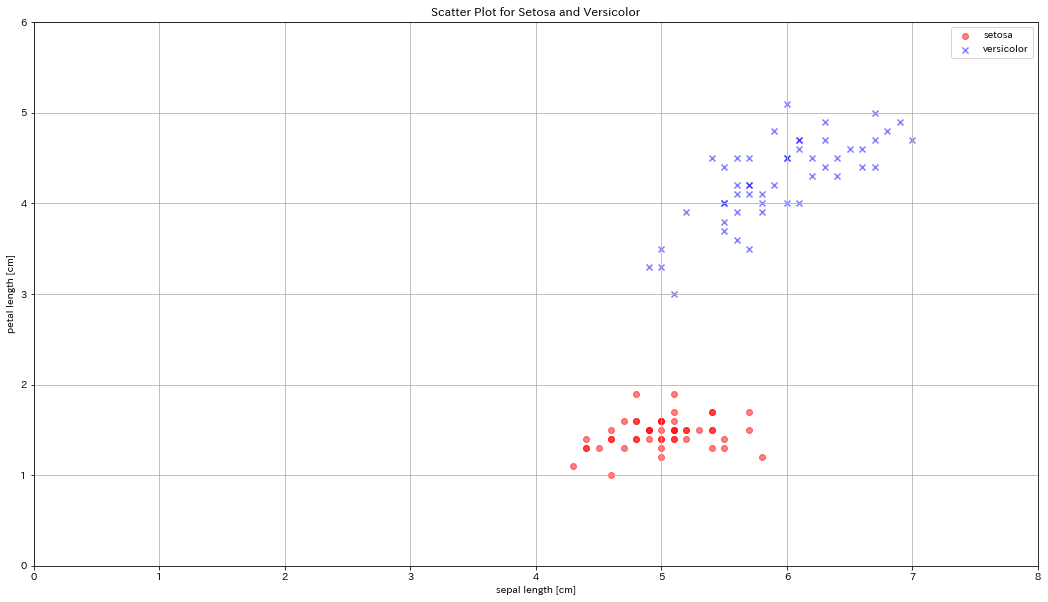

In [6]:
fig, ax = plt.subplots(1, 1, figsize=(18, 10))
ax.scatter(df_iris_setosa['sepal_length'], df_iris_setosa['petal_length'],
           color='red', marker='o', label='setosa', alpha=0.5)
ax.scatter(df_iris_versicolor['sepal_length'], df_iris_versicolor['petal_length'],
           color='blue', marker='x', label='versicolor', alpha=0.5)
ax.set_xlim([0.0, 8.0])
ax.set_ylim([0.0, 6.0])
ax.grid()
ax.legend()
ax.set_xlabel("sepal length [cm]")
ax.set_ylabel("petal length [cm]")
ax.set_title("Scatter Plot for Setosa and Versicolor")
fig.show()

Likewise, the scatter plot of `sepal_width` and `petal_width`.

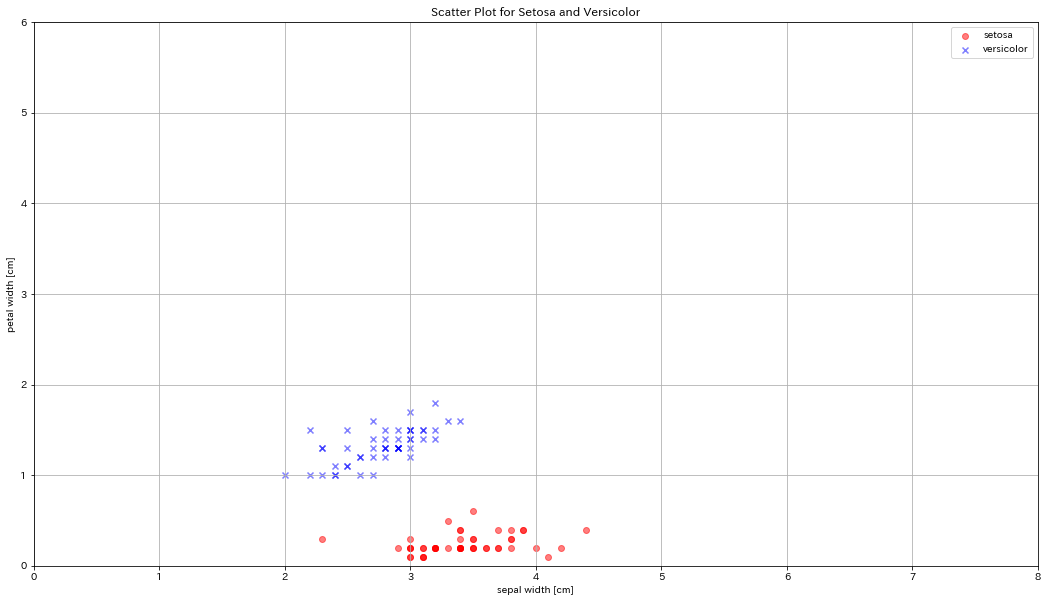

In [7]:
fig, ax = plt.subplots(1, 1, figsize=(18, 10))
ax.scatter(df_iris_setosa['sepal_width'], df_iris_setosa['petal_width'],
           color='red', marker='o', label='setosa', alpha=0.5)
ax.scatter(df_iris_versicolor['sepal_width'], df_iris_versicolor['petal_width'],
           color='blue', marker='x', label='versicolor', alpha=0.5)
ax.set_xlim([0.0, 8.0])
ax.set_ylim([0.0, 6.0])
ax.grid()
ax.legend()
ax.set_xlabel("sepal width [cm]")
ax.set_ylabel("petal width [cm]")
ax.set_title("Scatter Plot for Setosa and Versicolor")
fig.show()

In [20]:
@dataclass
class Perceptron:
    """A simple perceptron as a binary classifier.

    Args:
      eta (float): A learning rate selected between 0.0 and 1.0.
      num_iter (int): The number of iteration for tranining.
      seed (int): A random state seed set to a random number generator for weight initialization.

    Attrs:
      w_ (ndarray): An array of weights/bias obtained after training.
      errors_ (ndarray): A collection of errors computed at each epoch.
    """
    # Once defined, the following params are not expected to be modified.
    eta: float = 0.01
    num_iters: int = 50
    seed: int = 42
    rs: RandomState = RandomState(seed)

    def fit(self, X: Union[DataFrame, ndarray], y: Union[DataFrame, Series, ndarray]) -> None:
        """Fit the perceptron model to the input traning data.

        Args:
          X (Union[DataFrame, ndarray]): A collection of training samples, where X.shape[0] is
                                         the number of instances and X.shape[1] the number of
                                         features.
          y (Union[DataFame, Series, ndarray]): A one-dimensional array of target values.
        """
        if isinstance(X, DataFrame):
            X: ndarray = X.values
        if isinstance(y, DataFrame) or isinstance(y, Series):
            y: ndarray = y.values

        # Initialize the training weights with random numbers from the normal distribution with
        # mean 0.0 and standard deviation 0.01
        loc: float = 0.0
        scale: float = 0.01
        size: int = 1 + X.shape[1]
        self.w_: ndarray = self.rs.normal(loc=loc, scale=scale, size=size)

        # Perform fitting on training samples and measure errors
        self.errors_: ndarray = np.empty(shape=(self.num_iters,))
        for i in range(self.num_iters):
            error_: int = 0
            for xi, target in zip(X, y):
                coeff_: float = self.eta * (target - self.predict(xi))
                self.w_[1:] += coeff_ * xi
                self.w_[0] += coeff_
                error_ += int(coeff_ != 0.0)
            self.errors_[i] = error_

        # Make weights and errors immutable
        self.w_.setflags(write=False)
        self.errors_.setflags(write=False)

    def evaluate(self, X: Union[DataFrame, ndarray]) -> ndarray:
        """Evaluate the perceptron with given inputs and weights/bias.

        Arg:
          X (Union[DataFrame, ndarray]): A collection of instances with features to be
                                         evaluated.

        Return:
          _ (ndarray): The computed vector, X multiplied by w (matrix multiplication),
                       added by a bias term.
        """
        if isinstance(X, DataFrame):
            X: ndarray = X.values
        return np.dot(X, self.w_[1:]) + self.w_[0]

    def predict(self, X: Union[DataFrame, ndarray]) -> ndarray:
        """Return class labels from the given inputs.

        Arg:
          X (Union[DataFrame, ndarray]): A collection of instances with features to be
                                         predicted.

        Return:
          _ (ndarray): A collection of predicted class labels 1 or -1.
        """
        return np.where(self.evaluate(X) >= 0.0, 1, -1)

In [9]:
clf = Perceptron()

In [10]:
clf.eta

0.001

In [11]:
features = [
    df_iris_setosa[['sepal_length', 'petal_length']],
    df_iris_versicolor[['sepal_length', 'petal_length']]
]
X = pd.concat(features)

In [12]:
targets = [
    df_iris_setosa[['class_label']],
    df_iris_versicolor[['class_label']]
]
y = pd.concat(targets)
y = y.applymap(lambda x: 1 if x == 'Iris-setosa' else -1)

In [13]:
clf.w_

AttributeError: 'Perceptron' object has no attribute 'w_'

In [14]:
clf.fit(X, y)

In [18]:
clf.evaluate(X)

array([ 0.0056433 ,  0.00547983,  0.00570867,  0.00484231,  0.00556157,
        0.00471157,  0.00523462,  0.00516925,  0.00507115,  0.00508752,
        0.0054962 ,  0.00461347,  0.00539809,  0.00616635,  0.00700007,
        0.0057414 ,  0.00628082,  0.0056433 ,  0.00495678,  0.00525099,
        0.00471157,  0.00525099,  0.00680387,  0.00446637,  0.00343654,
        0.00477694,  0.00477694,  0.00533273,  0.00572504,  0.00453174,
        0.00461347,  0.0054962 ,  0.00533273,  0.00597024,  0.00508752,
        0.00634619,  0.00636256,  0.00508752,  0.00546346,  0.00525099,
        0.00595388,  0.0055452 ,  0.00546346,  0.00477694,  0.00368174,
        0.00539809,  0.00485868,  0.00523462,  0.00541446,  0.00556157,
       -0.00575   , -0.00545579, -0.00661636, -0.00422985, -0.00576637,
       -0.00602794, -0.00632215, -0.00197409, -0.00568463, -0.00408275,
       -0.00267697, -0.00468753, -0.00382118, -0.00648562, -0.00257887,
       -0.00481827, -0.00610968, -0.00437696, -0.00561926, -0.00

In [16]:
clf.predict(X)

array([ 1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1])

In [17]:
clf.errors_.shape

(1000,)